In [1]:
import os
from collections import Counter
from numpy import float32
import json
import pandas as pd
from preprocessing_text import *
from computing_PMI import *
from tqdm import tqdm
import seaborn as sns
from statsmodels.stats.weightstats import ztest
from gensim.models import KeyedVectors
import numpy as np
from sklearn.manifold import TSNE
import random
from responsibly.we import weat
from matplotlib import pylab as plt
from scipy import stats
from sklearn.manifold import TSNE
from matplotlib import pylab as plt
import responsibly
from responsibly.we import BiasWordEmbedding
import logging

[nltk_data] Downloading package stopwords to /home/nicola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# A seed value is fixed for the replicability of experiments
seed_value = 42  
random.seed(seed_value)

In [3]:
def invoc(d):
    for k,v in d.items():
        for p in v[0]:
            if p not in we_genero.model.index2word :
                v[0].remove(p)
        for p in v[1]:
            if p not in we_genero.model.index2word :
                v[1].remove(p)
    return d

In [4]:
f = open(os.getcwd()+'/data/seeds/dict_PMI_WE.json')
seeds = json.load(f)

In [5]:
for k,v in seeds.items():
    seeds[k] = list(set(v))

In [6]:
len(seeds)

39

In [7]:
with open(os.getcwd()+'/data/tokens/sentences_tokens.txt', 'r') as f:
    l1 = []
    for ele in f:
        line = ele.split()
        l1.append(line)

In [8]:
tokens_l = list(map(l_of_ls, l1))

In [9]:
tokens_l = [lst for lst in tokens_l if lst is not None and any(lst)]

In [10]:
tokens_l = [[t for t in ts if t != ''] for ts in tokens_l]

In [11]:
all_tokens = [elemento for lista in tokens_l if lista for elemento in lista]

In [12]:
freq = Counter(all_tokens)

In [13]:
A_g = seeds["espacio_m"]
B_g = seeds["espacio_f"]
A_r = seeds['christianity words']
B_r = seeds["islam words"]

In [14]:
seeds.pop("espacio_m")
seeds.pop("espacio_f")
seeds.pop("christianity words")
seeds.pop("islam words")
seeds.pop("profesiones_male")
seeds.pop("profesiones_female")
seeds.pop("islam")
seeds.pop("pleasant 6") # uguale a pleasantness
seeds.pop("unpleasant 6") # uguale a unpleasantness

['desagradable', 'horrible', 'agonía', 'fracaso', 'guerra', 'terrible']

In [15]:
seeds.keys()

dict_keys(['pleasant', 'unpleasant', 'instruments', 'weapons', 'pleasantness', 'unpleasantness', 'career', 'family', 'math 1', 'arts 1', 'science 1', 'arts 2', 'physically ill', 'temporary', 'permanent', 'christianity', 'terrorism', 'clothing', 'sports', 'family words', 'career words', 'violence', 'domestic_work', 'positive_emotion', 'negative_emotion', 'profesiones_neutras', 'verbos', 'profesiones_colectivos', 'sustantivos_abstractos', 'adjetivos_neutros'])

In [16]:
len(seeds.keys())

30

In [17]:
freq['amable']

97

In [18]:
pmi_g = list_pmi(seeds, A_g, B_g, tokens_l, freq)

100%|██████████| 30/30 [01:31<00:00,  3.05s/it]


In [19]:
comp_freq(pmi_g, seeds, freq)

In [20]:
pmi_r = list_pmi(seeds, A_r, B_r, tokens_l, freq)

100%|██████████| 30/30 [02:25<00:00,  4.86s/it]


In [21]:
comp_freq(pmi_r, seeds, freq)

In [22]:
df_g = pd.DataFrame.from_dict(pmi_g, orient='index', columns = ["PMI", "freq_mean"])

In [23]:
df_r = pd.DataFrame.from_dict(pmi_r, orient='index', columns = ["PMI", "freq_mean"])

In [24]:
df_g = df_g[df_g['PMI'] != False]

In [25]:
df_r = df_r[df_r['PMI'] != False]

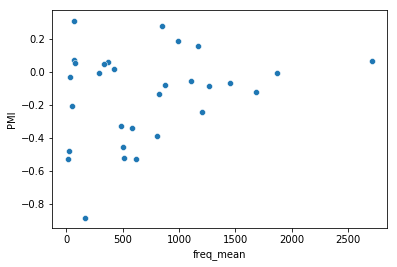

In [26]:
sns.scatterplot(x="freq_mean", y="PMI", data=df_g)

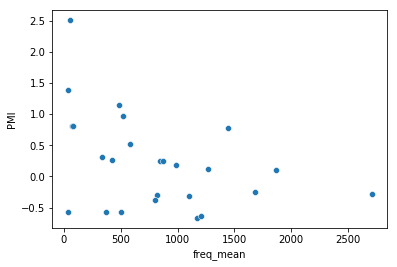

In [27]:
sns.scatterplot(x="freq_mean", y="PMI", data=df_r)

In [28]:
r_g = np.corrcoef(df_g.loc[:,"PMI"].astype(float32), df_g.loc[:,"freq_mean"].astype(float32))#0.24 0.25 0.242
round(r_g[0,1],2)

0.24

In [29]:
r_r = np.corrcoef(df_r.loc[:,"PMI"].astype(float32), df_r.loc[:,"freq_mean"].astype(float32))#-0.41 -0.41 -0.41
round(r_r[0,1],2)

-0.41

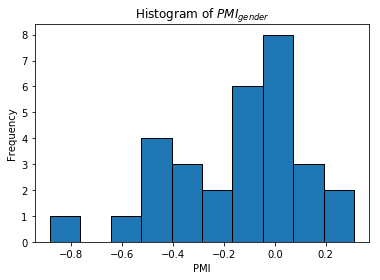

In [30]:
plt.hist(df_g.loc[:,"PMI"].astype(float32), bins=10, edgecolor='black')

# Aggiungi etichette agli assi e un titolo
plt.xlabel('PMI')
plt.ylabel('Frequency')
plt.title('Histogram of $PMI_{gender}$')

# Mostra l'istogramma
plt.show()

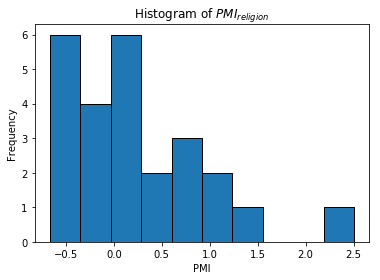

In [31]:
plt.hist(df_r.loc[:,"PMI"].astype(float32), bins=10, edgecolor='black')

# Aggiungi etichette agli assi e un titolo
plt.xlabel('PMI')
plt.ylabel('Frequency')
plt.title('Histogram of $PMI_{religion}$')

# Mostra l'istogramma
plt.show()

In [32]:
ztest_Score_g, p_value_g = ztest(df_g.loc[:,"PMI"], value = 0.0, alternative='two-sided')#0.0053188242738449465 0.00532
round(p_value_g,5)

0.00532

In [33]:
ztest_Score_r, p_value_r = ztest(df_r.loc[:,"PMI"], value = 0.0, alternative='two-sided')#0.12617294102300938 0.12617
round(p_value_r,5)

0.12617

In [34]:
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################

In [35]:
# WE

In [36]:
file_path = os.getcwd()+'/data/WE/emb_pr_es_30.vec'
model = KeyedVectors.load_word2vec_format(file_path, binary=False)

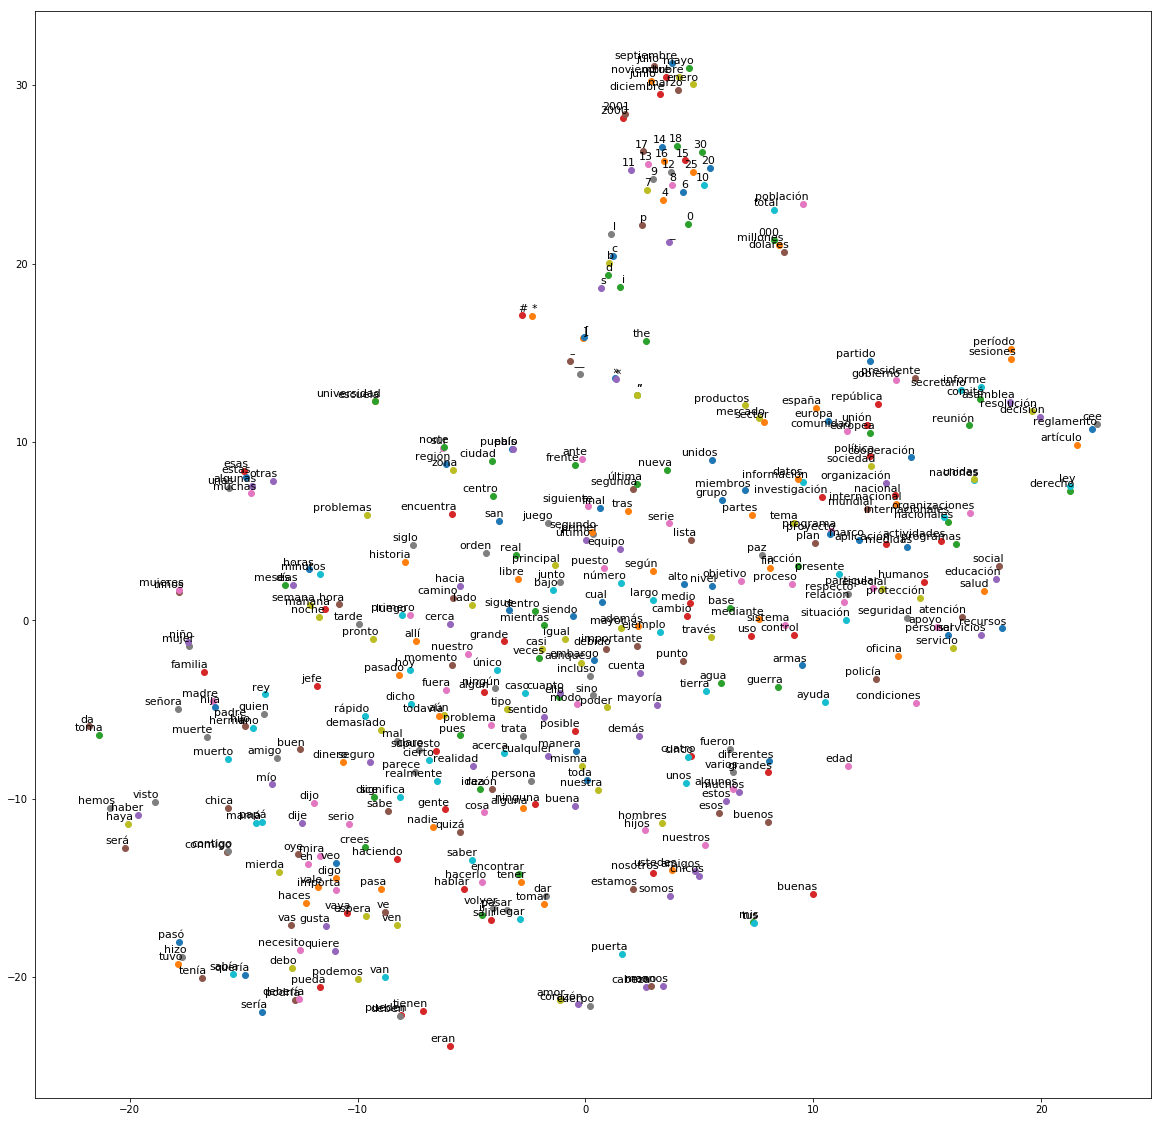

In [37]:
# take the most common words in the corpus between 200 and 600
words = [word for word in model.index2word[200:600]]

# convert the words to vectors
embeddings = np.array([model[word] for word in words])
# perform T-SNE
words_embedded = TSNE(n_components=2).fit_transform(embeddings)

# ... and visualize!
plt.figure(figsize=(20, 20))
for i, label in enumerate(words):
    x, y = words_embedded[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom', size=11)
plt.show()

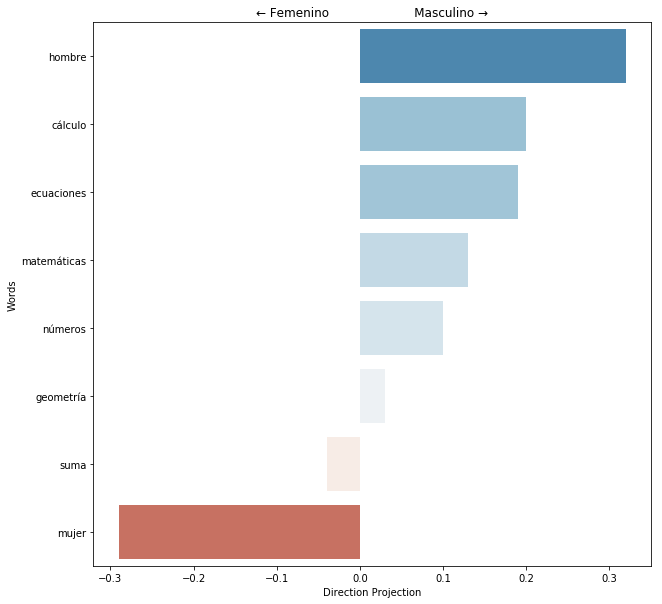

In [38]:
we_genero = BiasWordEmbedding(model, only_lower=True)
we_genero._identify_direction('Masculino', 'Femenino',
                                          definitional=(A_g, B_g),
                                          method='sum')
f, ax = plt.subplots(1, figsize=(10, 10))
we_genero.plot_projection_scores(
    seeds["math 1"]+["hombre"]+["mujer"],# + espacio_f[:1] + espacio_m[:1],
    n_extreme=20,
    ax=ax);

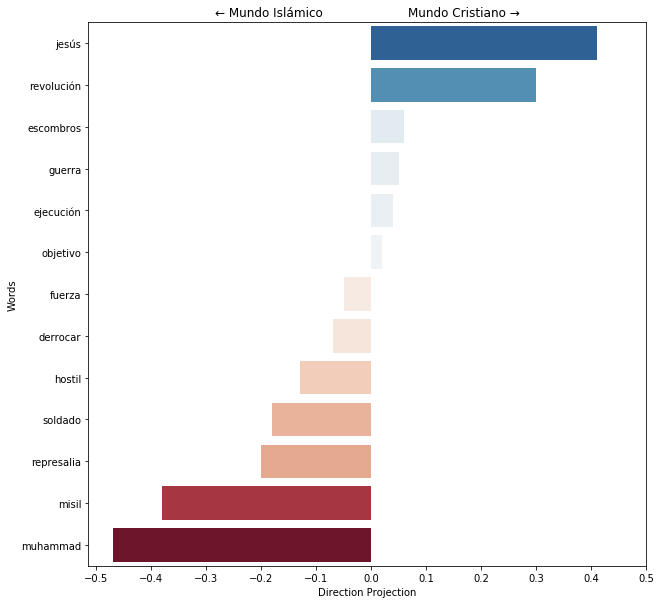

In [39]:
we_relig = BiasWordEmbedding(model, only_lower=True)
we_relig._identify_direction('Mundo Cristiano', 'Mundo Islámico',
                                          definitional=(A_r, B_r),
                                          method='sum')
f, ax = plt.subplots(1, figsize=(10, 10))
we_relig.plot_projection_scores(
    random.sample(seeds["terrorism"],10)+["misil"]+['jesús']+['muhammad'],
    n_extreme=20,
    ax=ax);

In [40]:
keys_f_g = list(df_g.index)
keys_f_r = list(df_r.index)
db_g = {}
for k in keys_f_g :
    W = list(seeds[k]) 
    for w in W:    
        if w not in we_genero.model.index2word :
            W.remove(w)
    db_g[k] = we_genero.calc_direct_bias(W, c=None)

In [41]:
db_r = {}
for k in keys_f_r :
    W = list(seeds[k]) 
    for w in W:    
        if w not in we_genero.model.index2word :
            W.remove(w)
    db_r[k] = we_relig.calc_direct_bias(W, c=None)

In [42]:
type(df_g.loc[:,"PMI"])

pandas.core.series.Series

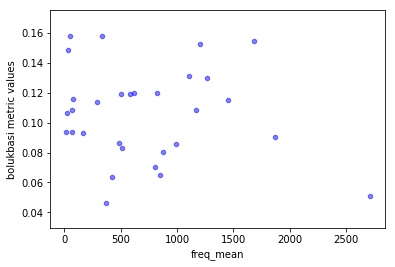

In [43]:
plt.scatter(df_g.loc[:,"freq_mean"], list(db_g.values()), c='blue',s=20, alpha=0.5)

plt.xlabel("freq_mean")
plt.ylabel("bolukbasi metric values")
plt.show()

In [44]:
r_g1 = np.corrcoef(df_g.loc[:,"freq_mean"], list(db_g.values()))#-0.13
round(r_g1[0,1],2)

-0.14

In [45]:
r_g1 = np.corrcoef(np.array(df_g.loc[:,"PMI"]).astype('float32'), list(db_g.values()))#-0.09
round(r_g1[0,1],2)

-0.1

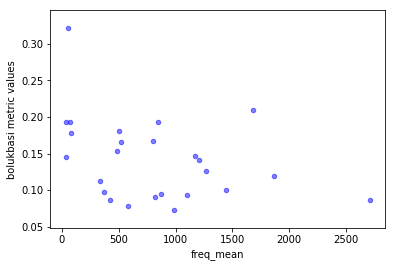

In [46]:
plt.scatter(df_r.loc[:,"freq_mean"], list(db_r.values()), c='blue',s=20, alpha=0.5)

plt.xlabel("freq_mean")
plt.ylabel("bolukbasi metric values")
plt.show()

In [47]:
r_g2 = np.corrcoef(df_r.loc[:,"freq_mean"], list(db_r.values()))#-0.37
round(r_g2[0,1],2)

-0.37

In [48]:
r_g2 = np.corrcoef(np.array(df_r.loc[:,"PMI"]).astype('float32'), list(db_r.values()))#0.44
round(r_g2[0,1],2)

0.44

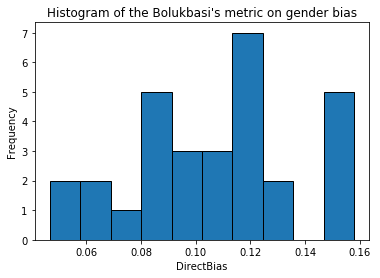

In [49]:
plt.hist(list(db_g.values()), bins=10, edgecolor='black')

# Aggiungi etichette agli assi e un titolo
plt.xlabel('DirectBias')
plt.ylabel('Frequency')
plt.title("Histogram of the Bolukbasi's metric on gender bias")

# Mostra l'istogramma
plt.show()

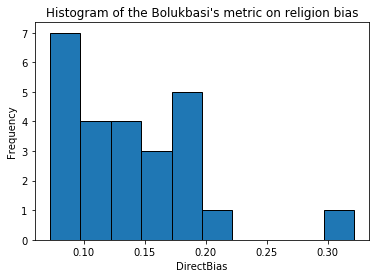

In [50]:
plt.hist(list(db_r.values()), bins=10, edgecolor='black')

# Aggiungi etichette agli assi e un titolo
plt.xlabel('DirectBias')
plt.ylabel('Frequency')
plt.title("Histogram of the Bolukbasi's metric on religion bias")

# Mostra l'istogramma
plt.show()

In [51]:
ztest_Score_g, p_value_g = ztest(list(db_g.values()), value = 0.0, alternative='two-sided')#3.197867413085225e-78
p_value_g

1.9464760197460484e-78

In [52]:
ztest_Score_r, p_value_r = ztest(list(db_r.values()), value = 0.0, alternative='two-sided')#3.5039766047728225e-36
p_value_r

4.290293463829364e-36

In [53]:
################################################################################################################
################################################################################################################

In [54]:
fa_science_1 =  seeds['math 1']
sa_arts_1 =  seeds['arts 1']
fa_science_2 =  seeds['science 1']
sa_arts_2 =  seeds['arts 2']
fa_ins = seeds['instruments']
sa_wea = seeds['weapons']
fa_car_1 =  seeds['career']
sa_fam_1 =  seeds['family']
fa_car_2 =  seeds['career words']
sa_fam_2 =  seeds['family words']
fa_pl_1 =  seeds['pleasant']
sa_unpl_1 = seeds['unpleasant']
fa_pl_2 =  seeds['pleasantness']
sa_unpl_2 = seeds['unpleasantness']

attr_g = {"math 1_arts 1":[fa_science_1, sa_arts_1],
          "science 1_arts 2":[fa_science_2, sa_arts_2],
          "career_family":[fa_car_1, sa_fam_1],
          "career words_family words":[fa_car_2, sa_fam_2],
          #"pleasant_unpleasant":[fa_pl_1, sa_unpl_1],
          "pleasantness_unpleasantness":[fa_pl_2, sa_unpl_2]
         }

attr_r = {"math 1_arts 1":[fa_science_1, sa_arts_1],
          "science 1_arts 2":[fa_science_2, sa_arts_2],
          "instruments_weapons":[fa_ins, sa_wea],
          #"pleasant_unpleasant":[fa_pl_1, sa_unpl_1],
          "pleasantness_unpleasantness":[fa_pl_2, sa_unpl_2]
         }

attr_g = invoc(attr_g)
attr_r = invoc(attr_r)

In [55]:
#    Attribute words (e.g., Male ve. Female)
#    Target words (e.g., Math vs. Arts)

In [56]:
first_target, second_target, first_attribute, second_attribute = {}, {}, {}, {}
first_attribute["words"] = A_g
first_attribute["name"] = "masc"
second_attribute["words"] =  B_g
second_attribute["name"] = "fem"
# Fissare seed per test permutazioni
l_g = []
for k,v in tqdm(attr_g.items()) :
    print(k)
    print(v)
    if len(v[0]) > len(v[1]) :
        length = len(v[1])
    else :
        length = len(v[0])  
    first_target["name"] = k.split("_")[0]
    first_target["words"] = random.sample(v[0],length)

    second_target["name"] = k.split("_")[1]
    second_target["words"] = random.sample(v[1],length)

    l_g.append(weat.calc_single_weat(model, first_target, 
                      second_target, first_attribute, 
                      second_attribute, with_pvalue=True, pvalue_kwargs=None))

  0%|          | 0/5 [00:00<?, ?it/s]

math 1_arts 1
[['suma', 'cálculo', 'matemáticas', 'números', 'geometría', 'ecuaciones'], ['danza', 'novela', 'poesía', 'drama', 'literatura', 'sinfonía', 'arte', 'escultura']]


100%|██████████| 5/5 [00:00<00:00,  7.47it/s]

science 1_arts 2
[['química', 'einstein', 'física', 'experimento', 'astronomía', 'tecnología', 'ciencia'], ['danza', 'novela', 'poesía', 'drama', 'literatura', 'sinfonía', 'arte']]
career_family
[['salario', 'carrera', 'oficina', 'negocio', 'corporación', 'gerencia', 'ejecutivo', 'profesional'], ['padres', 'familia', 'hogar', 'matrimonio', 'boda', 'parientes']]
career words_family words
[['salario', 'office', 'management', 'business'], ['padres', 'familia', 'hogar', 'primos', 'matrimonio', 'boda', 'parientes', 'hijos']]
pleasantness_unpleasantness
[['feliz', 'alegría', 'amor', 'risa', 'paz', 'placer'], ['desagradable', 'horrible', 'agonía', 'fracaso', 'guerra', 'terrible']]


In [57]:
# The results could be different due to the permutation test that is do in the weat package
first_target, second_target, first_attribute, second_attribute = {}, {}, {}, {}
first_target["words"] = random.sample(A_r,9)
first_target["name"] = "cris"
second_target["words"] = random.sample(B_r,9)
second_target["name"] = "isl"
l_r = []
for k,v in attr_r.items() :
    if len(v[0]) > len(v[1]) :
        length = len(v[1])
    else :
        length = len(v[0])  
    first_attribute["name"] = k.split("_")[0]
    first_attribute["words"] = random.sample(v[0],length)
    second_attribute["name"] = k.split("_")[1]
    second_attribute["words"] = random.sample(v[1],length)
    l_r.append(weat.calc_single_weat(model, first_target, 
                      second_target, first_attribute, 
                      second_attribute, with_pvalue=True, pvalue_kwargs=None))

In [58]:
l_g

[{'Target words': 'math 1 vs. arts 1',
  'Attrib. words': 'masc vs. fem',
  's': 0.4022880122065544,
  'd': 1.1516137,
  'p': 0.025974025974025976,
  'Nt': '6x2',
  'Na': '9x2'},
 {'Target words': 'science 1 vs. arts 2',
  'Attrib. words': 'masc vs. fem',
  's': 0.43256326019763947,
  'd': 0.9069402,
  'p': 0.05128205128205128,
  'Nt': '7x2',
  'Na': '9x2'},
 {'Target words': 'career vs. family',
  'Attrib. words': 'masc vs. fem',
  's': 0.45222246646881104,
  'd': 1.0677279,
  'p': 0.03896103896103896,
  'Nt': '6x2',
  'Na': '9x2'},
 {'Target words': 'career words vs. family words',
  'Attrib. words': 'masc vs. fem',
  's': 0.27246735990047455,
  'd': 1.3794348,
  'p': 0.014285714285714285,
  'Nt': '4x2',
  'Na': '9x2'},
 {'Target words': 'pleasantness vs. unpleasantness',
  'Attrib. words': 'masc vs. fem',
  's': -0.16689735651016235,
  'd': -0.50451446,
  'p': 0.7824675324675324,
  'Nt': '6x2',
  'Na': '9x2'}]

In [59]:
l_r

[{'Target words': 'cris vs. isl',
  'Attrib. words': 'math 1 vs. arts 1',
  's': -0.5529766827821732,
  'd': -0.8005848,
  'p': 0.950082270670506,
  'Nt': '9x2',
  'Na': '6x2'},
 {'Target words': 'cris vs. isl',
  'Attrib. words': 'science 1 vs. arts 2',
  's': -0.20684964954853058,
  'd': -0.31079486,
  'p': 0.7278280542986425,
  'Nt': '9x2',
  'Na': '7x2'},
 {'Target words': 'cris vs. isl',
  'Attrib. words': 'instruments vs. weapons',
  's': 1.0839758962392807,
  'd': 1.4451009,
  'p': 0.0004936240230357877,
  'Nt': '9x2',
  'Na': '11x2'},
 {'Target words': 'cris vs. isl',
  'Attrib. words': 'pleasantness vs. unpleasantness',
  's': 0.3024194538593292,
  'd': 0.4166758,
  'p': 0.19981489099136157,
  'Nt': '9x2',
  'Na': '6x2'}]

In [60]:
d1 = []
for el in l_g:
    d1.append(el['d'])

In [61]:
d1

[1.1516137, 0.9069402, 1.0677279, 1.3794348, -0.50451446]

In [62]:
d2 = []
for el in l_r:
    d2.append(el['d'])

In [63]:
d2

[-0.8005848, -0.31079486, 1.4451009, 0.4166758]

In [64]:
"""
l_freq = []
for el in A_g:
    l_freq.append({el:freq[el]})
l_freq
"""

'\nl_freq = []\nfor el in A_g:\n    l_freq.append({el:freq[el]})\nl_freq\n'

In [65]:
"""
l_freq = []
for el in B_g:
    l_freq.append({el:freq[el]})
l_freq
"""

'\nl_freq = []\nfor el in B_g:\n    l_freq.append({el:freq[el]})\nl_freq\n'

In [66]:
fa_science_1 =  seeds['math 1'] # Not contained in PMI
sa_arts_1 =  seeds['arts 1']
fa_science_2 =  seeds['science 1']
sa_arts_2 =  seeds['arts 2']
fa_car_1 =  seeds['career']
sa_fam_1 =  seeds['family']
fa_car_2 =  seeds['career words'] # Not contained in PMI
sa_fam_2 =  seeds['family words']
fa_pl_1 =  seeds['pleasant']
sa_unpl_1 = seeds['unpleasant']
fa_pl_2 =  seeds['pleasantness']
sa_unpl_2 = seeds['unpleasantness']
attr_g1 = {
          "science 1_arts 1":[fa_science_1, sa_arts_1],
          "science 1_arts 2":[fa_science_2, sa_arts_2],
          "career_family":[fa_car_1, sa_fam_1],
          "career words_family words":[fa_car_2, sa_fam_2],
          #"pleasant_unpleasant":[fa_pl_1, sa_unpl_1],
          "pleasantness_unpleasantness":[fa_pl_2, sa_unpl_2]
         }

In [67]:
first_target, second_target, first_attribute, second_attribute = {}, {}, {}, {}

A_g1, B_g1 = ['señor','él'], ['señora', 'ella']
A_g2, B_g2 = ['hombre','padre'], ['mujer', 'madre']
A_g3, B_g3 = ['chico','abuelo'], ['chica', 'abuela']
l_att = [[A_g1, B_g1], [A_g2, B_g2], [A_g3, B_g3]]

l_g1 = []
for att in tqdm(l_att):
    first_attribute["name"] = str(att[0])
    second_attribute["name"] = str(att[1])
    first_attribute["words"] = att[0]
    second_attribute["words"] = att[1]
    for k,v in attr_g1.items() :
        if len(v[0]) > len(v[1]) :
            length = len(v[1])
        else :
            length = len(v[0])  
        first_target["name"] = k.split("_")[0]
        first_target["words"] = random.sample(v[0],length)
        second_target["name"] = k.split("_")[1]
        second_target["words"] = random.sample(v[1],length)
        l_g1.append(weat.calc_single_weat(model, first_target, 
                      second_target, first_attribute, 
                      second_attribute, with_pvalue=True, pvalue_kwargs=None))

100%|██████████| 3/3 [00:00<00:00, 12.72it/s]


In [68]:
first_target, second_target, first_attribute, second_attribute = {}, {}, {}, {}
A_r1, B_r1 = ['iglesia','cristiano'], ['islam', 'musulmán']
A_r2, B_r2 = ['salvación','evangelio'], ['velo', 'mezquita']
A_r3, B_r3 = ['mesías','bautismo'], ['sultan', 'allah']
l_att = [[A_r1, B_r1], [A_r2, B_r2], [A_r3, B_r3]]

l_r1 = []
for att in tqdm(l_att):
    first_attribute["name"] = str(att[0])
    second_attribute["name"] = str(att[1])
    first_attribute["words"] = att[0]
    second_attribute["words"] = att[1]
    for k,v in attr_r.items() :
        if len(v[0]) > len(v[1]) :
            length = len(v[1])
        else :
            length = len(v[0])  
        first_target["name"] = k.split("_")[0]
        first_target["words"] = random.sample(v[0],length)
        second_target["name"] = k.split("_")[1]
        second_target["words"] = random.sample(v[1],length)
        l_r1.append(weat.calc_single_weat(model, first_target, 
                      second_target, first_attribute, 
                      second_attribute, with_pvalue=True, pvalue_kwargs=None))

100%|██████████| 3/3 [00:30<00:00, 10.22s/it]


In [69]:
l_g1

[{'Target words': 'science 1 vs. arts 1',
  'Attrib. words': "['señor', 'él'] vs. ['señora', 'ella']",
  's': 0.6899484694004059,
  'd': 1.6656997,
  'p': 0.0021645021645021645,
  'Nt': '6x2',
  'Na': '2x2'},
 {'Target words': 'science 1 vs. arts 2',
  'Attrib. words': "['señor', 'él'] vs. ['señora', 'ella']",
  's': 0.5280629396438599,
  'd': 1.1130006,
  'p': 0.016025641025641024,
  'Nt': '7x2',
  'Na': '2x2'},
 {'Target words': 'career vs. family',
  'Attrib. words': "['señor', 'él'] vs. ['señora', 'ella']",
  's': 0.36748459935188293,
  'd': 0.9882097,
  'p': 0.05844155844155844,
  'Nt': '6x2',
  'Na': '2x2'},
 {'Target words': 'career words vs. family words',
  'Attrib. words': "['señor', 'él'] vs. ['señora', 'ella']",
  's': 0.4023783653974533,
  'd': 1.6643465,
  'p': 0.0,
  'Nt': '4x2',
  'Na': '2x2'},
 {'Target words': 'pleasantness vs. unpleasantness',
  'Attrib. words': "['señor', 'él'] vs. ['señora', 'ella']",
  's': -0.13719740509986877,
  'd': -0.39243847,
  'p': 0.735930

In [70]:
(freq['señor']+freq['él']+freq['señora']+freq['ella'])/4

19970.75

In [71]:
(freq['chico']+freq['abuelo']+freq['chica']+freq['abuela'])/4

20.75

In [72]:
l_r1

[{'Target words': 'math 1 vs. arts 1',
  'Attrib. words': "['iglesia', 'cristiano'] vs. ['islam', 'musulmán']",
  's': -0.5042850971221924,
  'd': -0.93877,
  'p': 0.9361471861471862,
  'Nt': '6x2',
  'Na': '2x2'},
 {'Target words': 'science 1 vs. arts 2',
  'Attrib. words': "['iglesia', 'cristiano'] vs. ['islam', 'musulmán']",
  's': -0.15205568820238113,
  'd': -0.3527242,
  'p': 0.7135780885780886,
  'Nt': '7x2',
  'Na': '2x2'},
 {'Target words': 'instruments vs. weapons',
  'Attrib. words': "['iglesia', 'cristiano'] vs. ['islam', 'musulmán']",
  's': 1.9409490674734116,
  'd': 1.3128777,
  'p': 0.0006946098277367627,
  'Nt': '11x2',
  'Na': '2x2'},
 {'Target words': 'pleasantness vs. unpleasantness',
  'Attrib. words': "['iglesia', 'cristiano'] vs. ['islam', 'musulmán']",
  's': 0.6260063201189041,
  'd': 1.2141101,
  'p': 0.017316017316017316,
  'Nt': '6x2',
  'Na': '2x2'},
 {'Target words': 'math 1 vs. arts 1',
  'Attrib. words': "['salvación', 'evangelio'] vs. ['velo', 'mezquita

In [73]:
(freq['iglesia']+freq['cristiano']+freq['islam']+freq['musulmán'])/4

187.5

In [74]:
(freq['mesías']+freq['bautismo']+freq['sultan']+freq['allah'])/4

1.25

In [75]:
keys_g = ['math 1', 'arts 1', 'science 1', 'arts 2', 'career', 'family', 'career words', 'family words',
         'pleasant', 'unpleasant', 'pleasantness', 'unpleasantness']

In [76]:
dict_g = {key: seeds[key] for key in keys_g}
pmi_g1 = list_pmi(dict_g, A_g1, B_g1, tokens_l, freq)
pmi_g2 = list_pmi(dict_g, A_g2, B_g2, tokens_l, freq)
pmi_g3 = list_pmi(dict_g, A_g3, B_g3, tokens_l, freq)

100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


In [77]:
pmi_g2

{'math 1': [0.32634566528361686],
 'arts 1': [-0.36840923266442505],
 'science 1': [0.43344286063174353],
 'arts 2': [-0.36840923266442505],
 'career': [-0.5204560132983493],
 'family': [0.062429251223816894],
 'career words': [-0.2256084968684954],
 'family words': [-0.02137751203778849],
 'pleasant': [0.08697733501587293],
 'unpleasant': [0.18811369998499475],
 'pleasantness': [0.39845998623938117],
 'unpleasantness': [0.7854549643084142]}

In [78]:
l_g1

[{'Target words': 'science 1 vs. arts 1',
  'Attrib. words': "['señor', 'él'] vs. ['señora', 'ella']",
  's': 0.6899484694004059,
  'd': 1.6656997,
  'p': 0.0021645021645021645,
  'Nt': '6x2',
  'Na': '2x2'},
 {'Target words': 'science 1 vs. arts 2',
  'Attrib. words': "['señor', 'él'] vs. ['señora', 'ella']",
  's': 0.5280629396438599,
  'd': 1.1130006,
  'p': 0.016025641025641024,
  'Nt': '7x2',
  'Na': '2x2'},
 {'Target words': 'career vs. family',
  'Attrib. words': "['señor', 'él'] vs. ['señora', 'ella']",
  's': 0.36748459935188293,
  'd': 0.9882097,
  'p': 0.05844155844155844,
  'Nt': '6x2',
  'Na': '2x2'},
 {'Target words': 'career words vs. family words',
  'Attrib. words': "['señor', 'él'] vs. ['señora', 'ella']",
  's': 0.4023783653974533,
  'd': 1.6643465,
  'p': 0.0,
  'Nt': '4x2',
  'Na': '2x2'},
 {'Target words': 'pleasantness vs. unpleasantness',
  'Attrib. words': "['señor', 'él'] vs. ['señora', 'ella']",
  's': -0.13719740509986877,
  'd': -0.39243847,
  'p': 0.735930

In [79]:
keys_r = ['math 1', 'arts 1', 'science 1', 'arts 2', 'instruments', 'weapons',
         'pleasant', 'unpleasant', 'pleasantness', 'unpleasantness']

In [80]:
dict_r = {key: seeds[key] for key in keys_r}
pmi_g1 = list_pmi(dict_r, A_r1, B_r1, tokens_l, freq)
pmi_g2 = list_pmi(dict_r, A_r2, B_r2, tokens_l, freq)
pmi_g3 = list_pmi(dict_r, A_r3, B_r3, tokens_l, freq)

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


In [81]:
l_rt

NameError: name 'l_rt' is not defined

In [ ]:
l_rt